# HOUSE PRICES PREDICTION

### Plan:
1. Log transform target variable
2. Divide data on categorical and numerical attributes
3. Processing missing values of numerical attributes
4. Processing outliers for numerical attributes (Log transform)
5. Feature selection (Correlation matrix, PCA)
6. Processing missing values of categorical attributes (train clf to predict missing values) 
7. Feature selection (Anova)
8. Encoding (OneHotEncoder)
9. Create a pipeline
10. Train RandomForestRegressor (GridSearchCV) or AdaBoostRegressor  
11. Model score (for AdaBoostRegressor cross_val_score)

useful content:
- https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf
- https://towardsdatascience.com/categorical-feature-selection-via-chi-square-fc558b09de43
- https://machinelearningmastery.com/feature-selection-with-numerical-input-data/

### Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

### Settings

In [4]:
pd.set_option('max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [5]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,CBlock,TA,TA,No,Rec,468.00,LwQ,144.00,270.00,882.00,GasA,TA,Y,SBrkr,896,0,0,896,0.00,0.00,1,0,2,1,TA,5,Typ,0,NaN,Attchd,"1,961.00",Unf,1.00,730.00,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.00,TA,TA,CBlock,TA,TA,No,ALQ,923.00,Unf,0.00,406.00,"1,329.00",GasA,TA,Y,SBrkr,1329,0,0,1329,0.00,0.00,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,"1,958.00",Unf,1.00,312.00,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,PConc,Gd,TA,No,GLQ,791.00,Unf,0.00,137.00,928.00,GasA,Gd,Y,SBrkr,928,701,0,1629,0.00,0.00,2,1,3,1,TA,6,Typ,1,TA,Attchd,"1,997.00",Fin,2.00,482.00,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.00,TA,TA,PConc,TA,TA,No,GLQ,602.00,Unf,0.00,324.00,926.00,GasA,Ex,Y,SBrkr,926,678,0,1604,0.00,0.00,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,"1,998.00",Fin,2.00,470.00,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,No,ALQ,263.00,Unf,0.00,"1,017.00","1,280.00",GasA,Ex,Y,SBrkr,1280,0,0,1280,0.00,0.00,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,"1,992.00",RFn,2.00,506.00,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df.shape

(1460, 81)

In [8]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,"1,460.00","1,460.00","1,201.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,452.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,379.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00"
mean,730.50,56.90,70.05,"10,516.83",6.10,5.58,"1,971.27","1,984.87",103.69,443.64,46.55,567.24,"1,057.43","1,162.63",346.99,5.84,"1,515.46",0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,"1,978.51",1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,"2,007.82","180,921.20"
std,421.61,42.30,24.28,"9,981.26",1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,"79,442.50"
min,1.00,20.00,21.00,"1,300.00",1.00,1.00,"1,872.00","1,950.00",0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,"1,900.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,"2,006.00","34,900.00"
25%,365.75,20.00,59.00,"7,553.50",5.00,5.00,"1,954.00","1,967.00",0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,"1,129.50",0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,"1,961.00",1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,"2,007.00","129,975.00"
50%,730.50,50.00,69.00,"9,478.50",6.00,5.00,"1,973.00","1,994.00",0.00,383.50,0.00,477.50,991.50,"1,087.00",0.00,0.00,"1,464.00",0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,"1,980.00",2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,"2,008.00","163,000.00"
75%,"1,095.25",70.00,80.00,"11,601.50",7.00,6.00,"2,000.00","2,004.00",166.00,712.25,0.00,808.00,"1,298.25","1,391.25",728.00,0.00,"1,776.75",1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,"2,002.00",2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,"2,009.00","214,000.00"
max,"1,460.00",190.00,313.00,"215,245.00",10.00,9.00,"2,010.00","2,010.00","1,600.00","5,644.00","1,474.00","2,336.00","6,110.00","4,692.00","2,065.00",572.00,"5,642.00",3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,"2,010.00",4.00,"1,418.00",857.00,547.00,552.00,508.00,480.00,738.00,"15,500.00",12.00,"2,010.00","755,000.00"


In [9]:
df.isna().sum().to_numpy()

array([   0,    0,    0,  259,    0,    0, 1369,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    8,    8,    0,    0,    0,   37,   37,   38,
         37,    0,   38,    0,    0,    0,    0,    0,    0,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  690,   81,   81,   81,    0,    0,   81,   81,    0,
          0,    0,    0,    0,    0,    0, 1453, 1179, 1406,    0,    0,
          0,    0,    0,    0], dtype=int64)

In [10]:
target = df.SalePrice
target.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

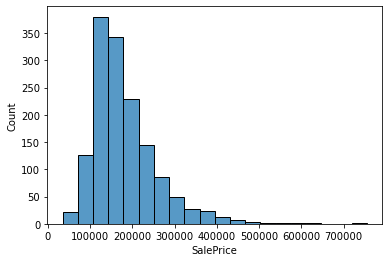

In [11]:
sns.histplot(target, bins=20);

### log target variable

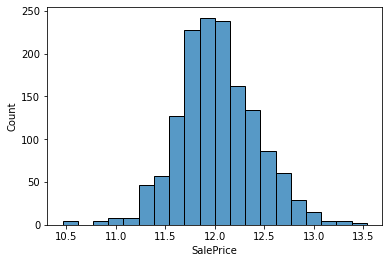

In [12]:
target = np.log(target)
sns.histplot(target, bins=20);

In [13]:
X = df.drop(['Id', 'SalePrice'], axis=1)
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [14]:
numerical_data = X.select_dtypes(['int64', 'float64'])
numerical_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.00,8450,7,5,2003,2003,196.00,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,"2,003.00",2,548,0,61,0,0,0,0,0,2,2008
1,20,80.00,9600,6,8,1976,1976,0.00,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,"1,976.00",2,460,298,0,0,0,0,0,0,5,2007
2,60,68.00,11250,7,5,2001,2002,162.00,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,"2,001.00",2,608,0,42,0,0,0,0,0,9,2008
3,70,60.00,9550,7,5,1915,1970,0.00,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,"1,998.00",3,642,0,35,272,0,0,0,0,2,2006
4,60,84.00,14260,8,5,2000,2000,350.00,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,"2,000.00",3,836,192,84,0,0,0,0,0,12,2008


In [15]:
categorical_data = X.select_dtypes(['object'])
categorical_data.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [16]:
print(numerical_data.shape)
print(categorical_data.shape)
print(X.shape)

(1460, 36)
(1460, 43)
(1460, 79)


# Working with numerical data

1. Processing missing values of numerical attributes
2. Processing outliers for numerical attributes (StandardScaler)
3. PCA
4. Work with datetime
5. Feature selection (Correlation matrix)

In [17]:
def search_null_values(data):
    missing_values_data = data.isna().sum()
    missing_values_data = missing_values_data[missing_values_data > 0]
    
    if (missing_values_data.empty):
        return 'no missing values'
    else:
        return missing_values_data

In [18]:
search_null_values(numerical_data)

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

### Missing Values

# *1.*
SimpleImputer(strategy='median')

In [19]:
imputer = SimpleImputer(strategy='median')
numerical_data = pd.DataFrame(imputer.fit_transform(numerical_data), columns=list(numerical_data))

In [20]:
numerical_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60.00,65.00,"8,450.00",7.00,5.00,"2,003.00","2,003.00",196.00,706.00,0.00,150.00,856.00,856.00,854.00,0.00,"1,710.00",1.00,0.00,2.00,1.00,3.00,1.00,8.00,0.00,"2,003.00",2.00,548.00,0.00,61.00,0.00,0.00,0.00,0.00,0.00,2.00,"2,008.00"
1,20.00,80.00,"9,600.00",6.00,8.00,"1,976.00","1,976.00",0.00,978.00,0.00,284.00,"1,262.00","1,262.00",0.00,0.00,"1,262.00",0.00,1.00,2.00,0.00,3.00,1.00,6.00,1.00,"1,976.00",2.00,460.00,298.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,"2,007.00"
2,60.00,68.00,"11,250.00",7.00,5.00,"2,001.00","2,002.00",162.00,486.00,0.00,434.00,920.00,920.00,866.00,0.00,"1,786.00",1.00,0.00,2.00,1.00,3.00,1.00,6.00,1.00,"2,001.00",2.00,608.00,0.00,42.00,0.00,0.00,0.00,0.00,0.00,9.00,"2,008.00"
3,70.00,60.00,"9,550.00",7.00,5.00,"1,915.00","1,970.00",0.00,216.00,0.00,540.00,756.00,961.00,756.00,0.00,"1,717.00",1.00,0.00,1.00,0.00,3.00,1.00,7.00,1.00,"1,998.00",3.00,642.00,0.00,35.00,272.00,0.00,0.00,0.00,0.00,2.00,"2,006.00"
4,60.00,84.00,"14,260.00",8.00,5.00,"2,000.00","2,000.00",350.00,655.00,0.00,490.00,"1,145.00","1,145.00","1,053.00",0.00,"2,198.00",1.00,0.00,2.00,1.00,4.00,1.00,9.00,1.00,"2,000.00",3.00,836.00,192.00,84.00,0.00,0.00,0.00,0.00,0.00,12.00,"2,008.00"


In [21]:
search_null_values(numerical_data)

'no missing values'

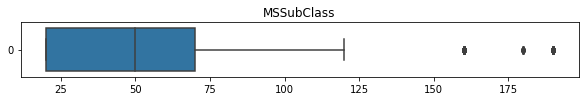

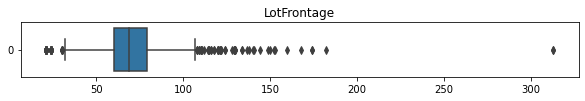

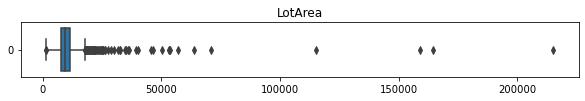

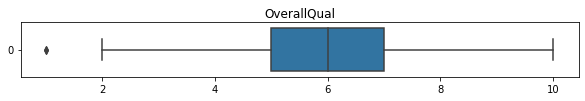

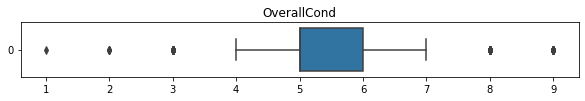

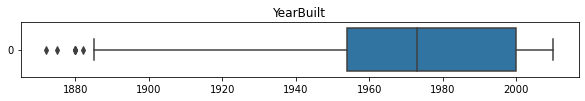

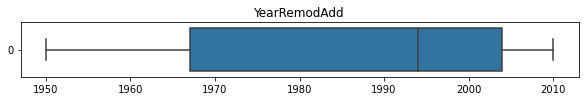

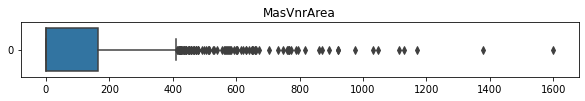

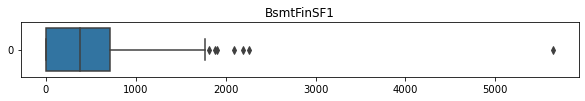

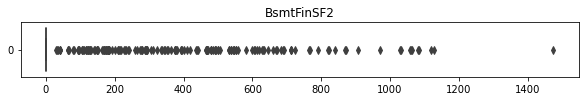

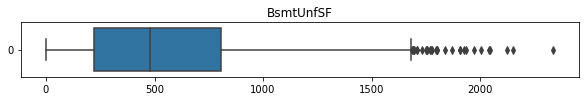

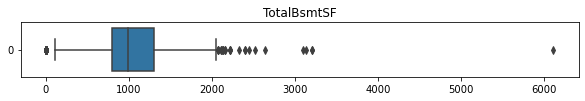

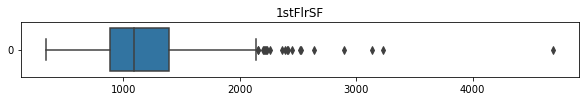

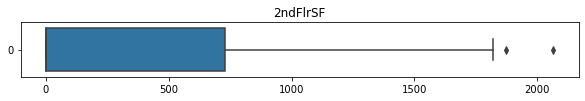

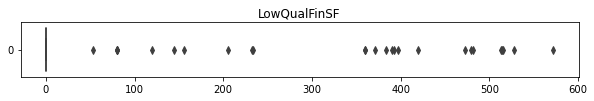

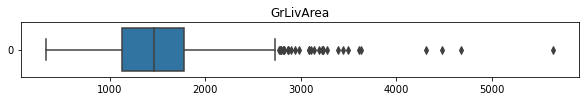

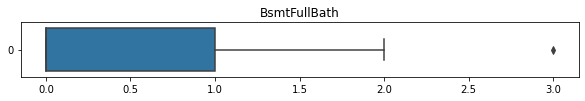

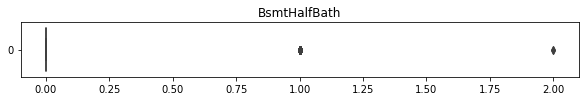

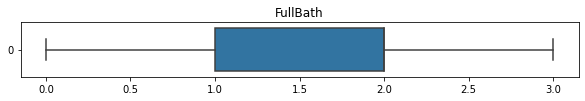

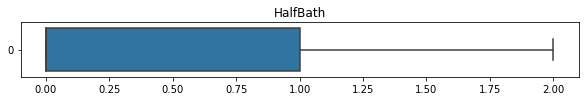

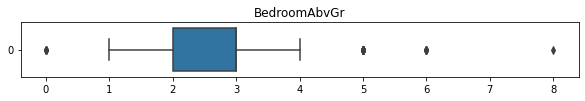

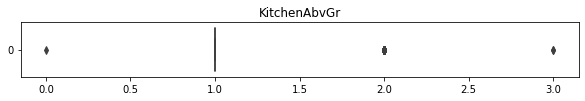

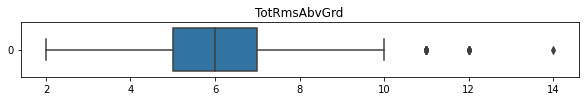

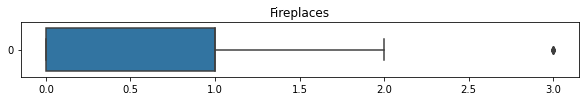

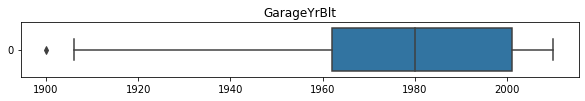

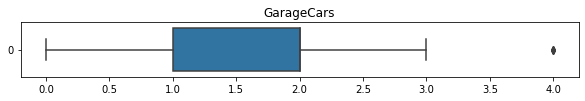

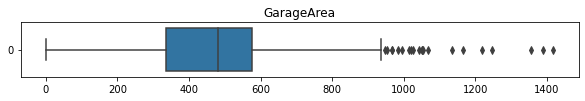

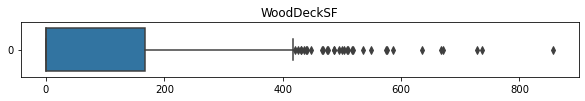

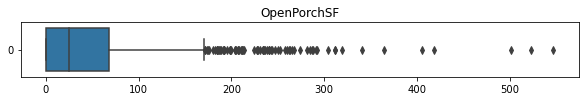

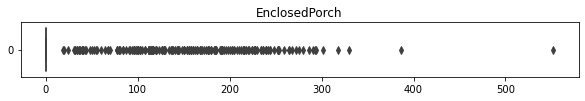

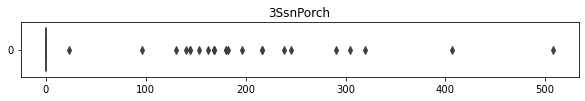

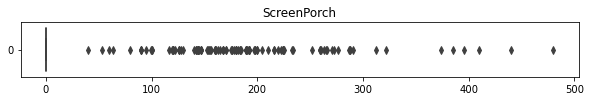

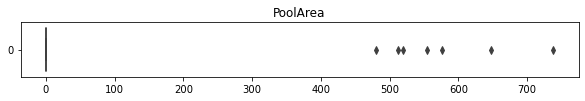

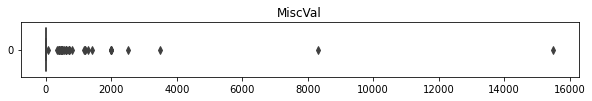

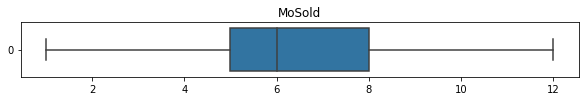

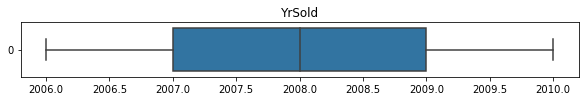

In [22]:
plt.rcParams['figure.max_open_warning'] = 100
for attribute in list(numerical_data):
    plt.figure(figsize=(10, 1))
    sns.boxplot(data=numerical_data[attribute], orient='horizontal')
    plt.title(attribute)

As we can see there are a lot of variables that have low dispersion (MiscVal, BsmtFinSF2...). Most likely they aren't significant

# VarianceThreshold. PCA. Correlation. OSL

In [23]:
numerical_data.shape

(1460, 36)

In [24]:
numerical_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,"1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00"
mean,56.90,69.86,"10,516.83",6.10,5.58,"1,971.27","1,984.87",103.12,443.64,46.55,567.24,"1,057.43","1,162.63",346.99,5.84,"1,515.46",0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,"1,978.59",1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,"2,007.82"
std,42.30,22.03,"9,981.26",1.38,1.11,30.20,20.65,180.73,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.00,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33
min,20.00,21.00,"1,300.00",1.00,1.00,"1,872.00","1,950.00",0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,"1,900.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,"2,006.00"
25%,20.00,60.00,"7,553.50",5.00,5.00,"1,954.00","1,967.00",0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,"1,129.50",0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,"1,962.00",1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,"2,007.00"
50%,50.00,69.00,"9,478.50",6.00,5.00,"1,973.00","1,994.00",0.00,383.50,0.00,477.50,991.50,"1,087.00",0.00,0.00,"1,464.00",0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,"1,980.00",2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,"2,008.00"
75%,70.00,79.00,"11,601.50",7.00,6.00,"2,000.00","2,004.00",164.25,712.25,0.00,808.00,"1,298.25","1,391.25",728.00,0.00,"1,776.75",1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,"2,001.00",2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,"2,009.00"
max,190.00,313.00,"215,245.00",10.00,9.00,"2,010.00","2,010.00","1,600.00","5,644.00","1,474.00","2,336.00","6,110.00","4,692.00","2,065.00",572.00,"5,642.00",3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,"2,010.00",4.00,"1,418.00",857.00,547.00,552.00,508.00,480.00,738.00,"15,500.00",12.00,"2,010.00"


### VarianceThreshold

In [25]:
thresholder = VarianceThreshold(threshold=0.5)
thresholder.fit(numerical_data)
print('Removed features:')
numerical_data.columns[~thresholder.get_support()].to_numpy()

Removed features:


array(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'KitchenAbvGr', 'Fireplaces'], dtype=object)

In [26]:
pd.DataFrame(thresholder.transform(numerical_data), columns=numerical_data.columns[thresholder.get_support()]).head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60.00,65.00,"8,450.00",7.00,5.00,"2,003.00","2,003.00",196.00,706.00,0.00,150.00,856.00,856.00,854.00,0.00,"1,710.00",3.00,8.00,"2,003.00",2.00,548.00,0.00,61.00,0.00,0.00,0.00,0.00,0.00,2.00,"2,008.00"
1,20.00,80.00,"9,600.00",6.00,8.00,"1,976.00","1,976.00",0.00,978.00,0.00,284.00,"1,262.00","1,262.00",0.00,0.00,"1,262.00",3.00,6.00,"1,976.00",2.00,460.00,298.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,"2,007.00"
2,60.00,68.00,"11,250.00",7.00,5.00,"2,001.00","2,002.00",162.00,486.00,0.00,434.00,920.00,920.00,866.00,0.00,"1,786.00",3.00,6.00,"2,001.00",2.00,608.00,0.00,42.00,0.00,0.00,0.00,0.00,0.00,9.00,"2,008.00"
3,70.00,60.00,"9,550.00",7.00,5.00,"1,915.00","1,970.00",0.00,216.00,0.00,540.00,756.00,961.00,756.00,0.00,"1,717.00",3.00,7.00,"1,998.00",3.00,642.00,0.00,35.00,272.00,0.00,0.00,0.00,0.00,2.00,"2,006.00"
4,60.00,84.00,"14,260.00",8.00,5.00,"2,000.00","2,000.00",350.00,655.00,0.00,490.00,"1,145.00","1,145.00","1,053.00",0.00,"2,198.00",4.00,9.00,"2,000.00",3.00,836.00,192.00,84.00,0.00,0.00,0.00,0.00,0.00,12.00,"2,008.00"


In [27]:
numerical_data.shape

(1460, 36)

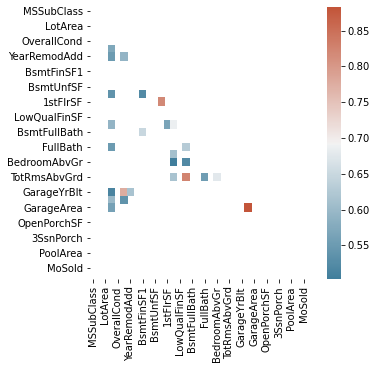

In [28]:
corr = numerical_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(5, 5))
sns.heatmap(corr[(corr > 0.5) | (corr < -0.5)], mask=mask, cmap=cmap);

### PCA

In [29]:
pca = PCA(n_components=0.99)

In [30]:
pca.fit_transform(numerical_data).shape

(1460, 3)

### OLS

In [31]:
X_ols = sm.add_constant(numerical_data)

ols = sm.OLS(target, numerical_data)
results = ols.fit()

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.874e+05
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                        0.00
Time:                        22:32:24   Log-Likelihood:                          744.51
No. Observations:                1460   AIC:                                     -1421.
Df Residuals:                    1426   BIC:                                     -1241.
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MSSubClass       -0.0006      0.000     -5.416      0.000      -0.001      -0.000
LotFrontage      -0.0002      0.000     -0.764      0.445      -0.001       0.000
LotArea         1.91e-06   4.32e-07      4.423      0.000    1.06e-06    2.76e-06
OverallQual       0.0839      0.005     16.715      0.000       0.074       0.094
OverallCond       0.0485      0.004     11.092      0.000       0.040       0.057
YearBuilt         0.0030      0.000     10.689      0.000       0.002       0.004
YearRemodAdd      0.0011      0.000      3.950      0.000       0.001       0.002
MasVnrArea     5.932e-07   2.51e-05      0.024      0.981   -4.87e-05    4.98e-05
BsmtFinSF1     2.918e-05   1.07e-05      2.726      0.006    8.18e-06    5.02e-05
BsmtFinSF2     1.553e-05   1.91e-05      0.815      0.415   -2.19e-05    5.29e-05
BsmtUnfSF      4.948e-06   1.02e-05      0.485      0.628   -1.51e-05     2.5e-05
TotalBsmtSF    4.966e-05   1.42e-05      3.486      0.001    2.17e-05    7.76e-05
1stFlrSF       5.796e-05   2.62e-05      2.215      0.027    6.62e-06       0.000
2ndFlrSF       3.256e-05   2.42e-05      1.344      0.179    -1.5e-05    8.01e-05
LowQualFinSF   4.792e-05   6.33e-05      0.757      0.449   -7.62e-05       0.000
GrLivArea         0.0001   2.41e-05      5.739      0.000    9.11e-05       0.000
BsmtFullBath      0.0613      0.011      5.562      0.000       0.040       0.083
BsmtHalfBath      0.0205      0.017      1.185      0.236      -0.013       0.054
FullBath          0.0382      0.012      3.191      0.001       0.015       0.062
HalfBath          0.0208      0.011      1.850      0.064      -0.001       0.043
BedroomAbvGr     -0.0018      0.007     -0.245      0.806      -0.016       0.012
KitchenAbvGr     -0.0525      0.022     -2.384      0.017      -0.096      -0.009
TotRmsAbvGrd      0.0160      0.005      3.053      0.002       0.006       0.026
Fireplaces        0.0454      0.008      6.044      0.000       0.031       0.060
GarageYrBlt      -0.0002      0.000     -0.794      0.427      -0.001       0.000
GarageCars        0.0672      0.012      5.521      0.000       0.043       0.091
GarageArea     3.012e-05   4.21e-05      0.716      0.474   -5.24e-05       0.000
WoodDeckSF        0.0001   3.39e-05      3.550      0.000    5.38e-05       0.000
OpenPorchSF   -2.558e-05   6.42e-05     -0.399      0.690      -0.000       0.000
EnclosedPorch     0.0002   7.13e-05      2.479      0.013    3.69e-05       0.000
3SsnPorch         0.0002      0.000      1.607      0.108    -4.7e-05       0.000
ScreenPorch       0.0004   7.27e-05      4.936      0.000       0.000       0.001
PoolArea         -0.0004      0.000     -3.573      0.000      -0.001      -0.000
MiscVal       -3.602e-06   7.85e

In [33]:
def backward_elimination(X, y, significance_level):
    X_selected = X.copy()
    columns = list(X)
    attributes_number = len(columns)
    
    for i in range(0, attributes_number):
        regressor_OLS = sm.OLS(y, X_selected).fit()
        
        maxValue = max(regressor_OLS.pvalues)
        if maxValue > significance_level:
            
            for j in range(0, attributes_number - i):
                
                if (regressor_OLS.pvalues[j] == maxValue):
                    X_selected = X_selected.drop(X_selected.columns[j], axis=1)
                    columns = np.delete(columns, j)
                    
    return X_selected, columns, regressor_OLS

In [34]:
selected_numerical_data, selected_numerical_columns, regressor_OLS = backward_elimination(numerical_data, target, 0.05)

In [35]:
print(selected_numerical_data.shape, numerical_data.shape)

(1460, 20) (1460, 36)


In [36]:
numerical_data = selected_numerical_data

In [37]:
numerical_features = selected_numerical_columns

In [38]:
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.898e+05
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                        0.00
Time:                        22:32:24   Log-Likelihood:                          739.10
No. Observations:                1460   AIC:                                     -1438.
Df Residuals:                    1440   BIC:                                     -1332.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MSSubClass       -0.0006      0.000     -5.956      0.000      -0.001      -0.000
LotArea        1.898e-06   4.23e-07      4.490      0.000    1.07e-06    2.73e-06
OverallQual       0.0832      0.005     17.023      0.000       0.074       0.093
OverallCond       0.0496      0.004     11.688      0.000       0.041       0.058
YearBuilt         0.0031      0.000     12.870      0.000       0.003       0.004
YearRemodAdd      0.0011      0.000      4.031      0.000       0.001       0.002
BsmtFinSF1     2.739e-05   1.28e-05      2.140      0.032    2.29e-06    5.25e-05
TotalBsmtSF    6.065e-05   1.32e-05      4.588      0.000    3.47e-05    8.66e-05
GrLivArea         0.0002   1.73e-05     11.022      0.000       0.000       0.000
BsmtFullBath      0.0583      0.010      5.779      0.000       0.039       0.078
FullBath          0.0288      0.011      2.661      0.008       0.008       0.050
KitchenAbvGr     -0.0507      0.021     -2.400      0.017      -0.092      -0.009
TotRmsAbvGrd      0.0146      0.005      3.153      0.002       0.006       0.024
Fireplaces        0.0480      0.007      6.623      0.000       0.034       0.062
GarageCars        0.0747      0.007     10.545      0.000       0.061       0.089
WoodDeckSF        0.0001   3.34e-05      3.669      0.000     5.7e-05       0.000
EnclosedPorch     0.0002   7.07e-05      2.402      0.016    3.11e-05       0.000
ScreenPorch       0.0004    7.2e-05      5.095      0.000       0.000       0.001
PoolArea         -0.0004   9.88e-05     -3.846      0.000      -0.001      -0.000
YrSold            0.0012      0.000      4.348      0.000       0.001       0.002
==============================================================================
Omnibus:                     1050.471   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57597.927
Skew:                          -2.754   Prob(JB):                         0.00
Kurtosis:                      33.273   Cond. No.                     8.20e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
numerical_data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,EnclosedPorch,ScreenPorch,PoolArea,YrSold
0,60.00,"8,450.00",7.00,5.00,"2,003.00","2,003.00",706.00,856.00,"1,710.00",1.00,2.00,1.00,8.00,0.00,2.00,0.00,0.00,0.00,0.00,"2,008.00"
1,20.00,"9,600.00",6.00,8.00,"1,976.00","1,976.00",978.00,"1,262.00","1,262.00",0.00,2.00,1.00,6.00,1.00,2.00,298.00,0.00,0.00,0.00,"2,007.00"
2,60.00,"11,250.00",7.00,5.00,"2,001.00","2,002.00",486.00,920.00,"1,786.00",1.00,2.00,1.00,6.00,1.00,2.00,0.00,0.00,0.00,0.00,"2,008.00"
3,70.00,"9,550.00",7.00,5.00,"1,915.00","1,970.00",216.00,756.00,"1,717.00",1.00,1.00,1.00,7.00,1.00,3.00,0.00,272.00,0.00,0.00,"2,006.00"
4,60.00,"14,260.00",8.00,5.00,"2,000.00","2,000.00",655.00,"1,145.00","2,198.00",1.00,2.00,1.00,9.00,1.00,3.00,192.00,0.00,0.00,0.00,"2,008.00"


# *2.*
StandardScaler

In [40]:
std = StandardScaler()
numerical_data = pd.DataFrame(std.fit_transform(numerical_data), columns=list(selected_numerical_data))

In [41]:
numerical_data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,EnclosedPorch,ScreenPorch,PoolArea,YrSold
0,0.07,-0.21,0.65,-0.52,1.05,0.88,0.58,-0.46,0.37,1.11,0.79,-0.21,0.91,-0.95,0.31,-0.75,-0.36,-0.27,-0.07,0.14
1,-0.87,-0.09,-0.07,2.18,0.16,-0.43,1.17,0.47,-0.48,-0.82,0.79,-0.21,-0.32,0.60,0.31,1.63,-0.36,-0.27,-0.07,-0.61
2,0.07,0.07,0.65,-0.52,0.98,0.83,0.09,-0.31,0.52,1.11,0.79,-0.21,-0.32,0.60,0.31,-0.75,-0.36,-0.27,-0.07,0.14
3,0.31,-0.10,0.65,-0.52,-1.86,-0.72,-0.50,-0.69,0.38,1.11,-1.03,-0.21,0.30,0.60,1.65,-0.75,4.09,-0.27,-0.07,-1.37
4,0.07,0.38,1.37,-0.52,0.95,0.73,0.46,0.20,1.30,1.11,0.79,-0.21,1.53,0.60,1.65,0.78,-0.36,-0.27,-0.07,0.14


In [42]:
regression_analysis = sm.OLS(target, numerical_data).fit()

In [43]:
regression_analysis.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.013
Method:                 Least Squares   F-statistic:                            0.06886
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                        1.00
Time:                        22:32:24   Log-Likelihood:                         -5702.6
No. Observations:                1460   AIC:                                  1.145e+04
Df Residuals:                    1440   BIC:                                  1.155e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MSSubClass       -0.0270      0.367     -0.074      0.941      -0.747       0.693
LotArea           0.0187      0.348      0.054      0.957      -0.664       0.701
OverallQual       0.1156      0.557      0.207      0.836      -0.978       1.209
OverallCond       0.0554      0.389      0.142      0.887      -0.708       0.819
YearBuilt         0.0919      0.597      0.154      0.878      -1.079       1.262
YearRemodAdd      0.0225      0.462      0.049      0.961      -0.883       0.928
BsmtFinSF1        0.0122      0.481      0.025      0.980      -0.932       0.956
TotalBsmtSF       0.0265      0.478      0.055      0.956      -0.911       0.964
GrLivArea         0.1002      0.750      0.134      0.894      -1.371       1.572
BsmtFullBath      0.0314      0.433      0.073      0.942      -0.818       0.881
FullBath          0.0166      0.491      0.034      0.973      -0.947       0.980
KitchenAbvGr     -0.0107      0.384     -0.028      0.978      -0.763       0.742
TotRmsAbvGrd      0.0230      0.619      0.037      0.970      -1.191       1.237
Fireplaces        0.0307      0.385      0.080      0.936      -0.724       0.785
GarageCars        0.0556      0.436      0.127      0.899      -0.800       0.912
WoodDeckSF        0.0158      0.345      0.046      0.964      -0.661       0.692
EnclosedPorch     0.0100      0.356      0.028      0.978      -0.689       0.709
ScreenPorch       0.0206      0.331      0.062      0.950      -0.629       0.670
PoolArea         -0.0159      0.328     -0.049      0.961      -0.659       0.627
YrSold           -0.0093      0.320     -0.029      0.977      -0.638       0.619
==============================================================================
Omnibus:                     1043.613   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56474.226
Skew:                          -2.730   Prob(JB):                         0.00
Kurtosis:                      32.976   Cond. No.                         6.51
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After doing *Backward elimination* and *Standardization* multicorrelation has disappeared

In [44]:
numerical_data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,EnclosedPorch,ScreenPorch,PoolArea,YrSold
0,0.07,-0.21,0.65,-0.52,1.05,0.88,0.58,-0.46,0.37,1.11,0.79,-0.21,0.91,-0.95,0.31,-0.75,-0.36,-0.27,-0.07,0.14
1,-0.87,-0.09,-0.07,2.18,0.16,-0.43,1.17,0.47,-0.48,-0.82,0.79,-0.21,-0.32,0.60,0.31,1.63,-0.36,-0.27,-0.07,-0.61
2,0.07,0.07,0.65,-0.52,0.98,0.83,0.09,-0.31,0.52,1.11,0.79,-0.21,-0.32,0.60,0.31,-0.75,-0.36,-0.27,-0.07,0.14
3,0.31,-0.10,0.65,-0.52,-1.86,-0.72,-0.50,-0.69,0.38,1.11,-1.03,-0.21,0.30,0.60,1.65,-0.75,4.09,-0.27,-0.07,-1.37
4,0.07,0.38,1.37,-0.52,0.95,0.73,0.46,0.20,1.30,1.11,0.79,-0.21,1.53,0.60,1.65,0.78,-0.36,-0.27,-0.07,0.14


It is prepeared data for training model

### Setting up a numerical pipeline

In [45]:
numerical_features

array(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch',
       'ScreenPorch', 'PoolArea', 'YrSold'], dtype='<U13')

In [46]:
numerical_pipeline = Pipeline([
    ('missing_values', SimpleImputer(strategy='median')),
    ('standardization', StandardScaler())
])

In [47]:
numerical_pipeline.fit_transform(df.select_dtypes(['int64', 'float64']))[0]

array([-1.731, 0.073, -0.221, -0.207, 0.651, -0.517, 1.051, 0.879, 0.514,
       0.575, -0.289, -0.945, -0.459, -0.793, 1.162, -0.120, 0.370, 1.108,
       -0.241, 0.790, 1.228, 0.164, -0.211, 0.912, -0.951, 1.018, 0.312,
       0.351, -0.752, 0.217, -0.359, -0.116, -0.270, -0.069, -0.088,
       -1.599, 0.139, 0.347])

# Categorical features

1. Processing missing values of categorical attributes (train clf to predict missing values)
2. Feature selection (Anova)
3. Encoding (OneHotEncoder)

In [48]:
categorical_data.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [49]:
search_null_values(categorical_data)

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Instantly drop all features which have more than 1000 null values

In [50]:
categorical_data = categorical_data.drop(['MiscFeature', 'Fence', 'PoolQC', 'Alley'], axis=1)

In [51]:
search_null_values(categorical_data)

MasVnrType        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [52]:
categorical_features = list(categorical_data)

In [53]:
categorical_data.shape

(1460, 39)

In [54]:
search_null_values(test_df.loc[:, categorical_features]).index.to_numpy()

array(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'SaleType'], dtype=object)

In [55]:
search_null_values(categorical_data)

MasVnrType        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [60]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, train_data, train_target_data, predicting_data=None):
        self.train_data = train_data.copy()
        self.train_target_data = train_target_data.copy()
        
        if predicting_data == None:
            self.predicting_data = train_data.copy()
        else:
            self.predicting_data = test_train_data.copy()
    
    def fit(self, X, predicting_data=None):
        if predicting_data != None:
            self.predicting_data = predicting_data
        
        return self
    
    def transform(self, X):
        self.predicting_data = X.select_dtypes(['int64', 'float64'])
        self.predicting_data = self.predicting_data[list(self.train_data)]
        self.predicting_target_data = X.select_dtypes(['object']).copy()
        
        features_with_null = search_null_values(self.predicting_target_data).index.values.tolist()
        
        for feature in features_with_null:
            null_rows = self.predicting_target_data[feature].isna()
            
            X_train = self.train_data[~null_rows]
            y_train = None
            
            try:
                y_train = self.train_target_data[feature]
            except Exception as e:
                print("data frame doesn't have such feature: ", feature)
                self.predicting_target_data = self.predicting_target_data.drop(feature, axis=1)
                continue
            
            y_train = y_train[~null_rows].astype(str)
            
            clf = self.train_model(X_train, y_train, feature)
            
            for row in null_rows.index.to_numpy():
                self.predicting_target_data.loc[row, feature] = clf.predict([self.predicting_data.loc[row, :]])[0]
                
        return self.predicting_target_data
    
    def train_model(self, X, y, feature):
        params = {'max_depth': [8, 11, 15], 'class_weight': ['balanced']}
        
        grid_search = GridSearchCV(RandomForestClassifier(), params, scoring='accuracy', cv=5)
        grid_search.fit(X, y)
        print(feature, ' accuracy: ' + str(grid_search.best_score_))
        
        return grid_search.best_estimator_
        

In [61]:
cat_imputer = CategoricalImputer(numerical_data, categorical_data)

In [62]:
output = cat_imputer.fit_transform(df)

data frame doesn't have such feature:  Alley
MasVnrType  accuracy: 0.7437919184737527
BsmtQual  accuracy: 0.8482283172720534
BsmtCond  accuracy: 0.9212947862614282
BsmtExposure  accuracy: 0.7236471460340994
BsmtFinType1  accuracy: 0.6872572275759822
BsmtFinType2  accuracy: 0.883264146281196
Electrical  accuracy: 0.9115849927034789
FireplaceQu  accuracy: 0.7181818181818181
GarageType  accuracy: 0.8114440052700923
GarageFinish  accuracy: 0.6860237154150198
GarageQual  accuracy: 0.9506877470355732
GarageCond  accuracy: 0.9608432147562583
data frame doesn't have such feature:  PoolQC
data frame doesn't have such feature:  Fence
data frame doesn't have such feature:  MiscFeature


In [63]:
search_null_values(output)

'no missing values'

In [64]:
categorical_data = output

In [65]:
categorical_data.shape

(1460, 39)

# OneHotEncoding

In [66]:
encoder = OneHotEncoder(drop='first')

In [67]:
encoded_categorical_data = np.array(encoder.fit_transform(categorical_data).todense())

In [68]:
categorical_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [69]:
encoder.get_feature_names(categorical_features)

array(['MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'Street_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod',
       'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Timber', 'Neighborhood_Veenker', 'Cond

In [70]:
encoded_categorical_data = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names(categorical_features))

In [71]:
encoded_categorical_data.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Gd,BsmtExposure_No,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
1,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,

In [72]:
encoded_categorical_data.shape

(1460, 159)

In [73]:
class Encoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
        
    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X:pd.DataFrame):
        X = X.copy()
        categorical_features = list(X)
        
        encoder = OneHotEncoder(drop='first')
        X = encoder.fit_transform(X)
        X = np.array(X.todense())
        X = pd.DataFrame(X, columns=encoder.get_feature_names(categorical_features))
        
        return X

In [74]:
test_encoder = Encoder()
test_encoder.fit_transform(categorical_data).head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Gd,BsmtExposure_No,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
1,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,

# Feature selection

- Null Hypothesis (H0): There is no relationship between the variables
- Alternative Hypothesis (H1): There is a relationship between variables

In [75]:
f_test = SelectKBest(score_func=f_classif, k='all')
f_test.fit(encoded_categorical_data, target)

SelectKBest(k='all')

In [76]:
f_test.scores_.shape

(159,)

In [77]:
pd.Series((f_test.pvalues_ < 0.05)).value_counts()

False    97
True     62
dtype: int64

In [78]:
encoded_categorical_data = encoded_categorical_data.loc[:, f_test.pvalues_ < 0.05]

In [79]:
encoded_categorical_data.shape

(1460, 62)

In [80]:
encoded_categorical_data.head()

,MSZoning_FV,Street_Pave,LotShape_IR3,LotShape_Reg,LandContour_HLS,LotConfig_CulDSac,LandSlope_Mod,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_IDOTRR,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_PosN,Condition1_RRAn,Condition2_PosN,Condition2_RRAn,Condition2_RRNn,HouseStyle_1.5Unf,HouseStyle_2.5Fin,HouseStyle_2Story,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofMatl_Membran,RoofMatl_WdShngl,Exterior1st_CemntBd,Exterior1st_ImStucc,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_Other,Exterior2nd_Stucco,Exterior2nd_VinylSd,MasVnrType_None,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Po,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,BsmtQual_Gd,BsmtExposure_No,Heating_Grav,Heating_Wall,CentralAir_Y,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,SaleType_Con,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Alloca,SaleCondition_Normal,SaleCondition_Partial
0,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
1,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
2,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00


In [81]:
encoded_categorical_features = list(encoded_categorical_data)

In [82]:
class ColumnSelection(BaseEstimator, TransformerMixin):

    def __init__(self, columns):
        if not isinstance(columns, list):
            self.columns = [columns]
        else:
            self.columns = columns

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X:pd.DataFrame):
        X = X.copy()
        return X[self.columns]

In [83]:
columns_selection = ColumnSelection(['GarageCond', 'GarageType'])

In [84]:
columns_selection.fit_transform(categorical_data).head()

,GarageCond,GarageType
0,TA,Attchd
1,TA,Attchd
2,TA,Attchd
3,TA,Attchd
4,TA,Attchd


In [85]:
encoded_categorical_features[:10]

['MSZoning_FV',
 'Street_Pave',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LotConfig_CulDSac',
 'LandSlope_Mod',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_IDOTRR']

# Setting up categorical pipeline

In [95]:
categorical_pipeline = Pipeline([
    ('missing_values', cat_imputer),
    ('encoder', Encoder()),
    ('feature_selection', ColumnSelection(encoded_categorical_features))
])

In [96]:
output = categorical_pipeline.fit_transform(df)

data frame doesn't have such feature:  Alley
MasVnrType  accuracy: 0.7417205830074652
BsmtQual  accuracy: 0.8468099827032368
BsmtCond  accuracy: 0.9212947862614282
BsmtExposure  accuracy: 0.7313664442797133
BsmtFinType1  accuracy: 0.694299481097109
BsmtFinType2  accuracy: 0.883264146281196
Electrical  accuracy: 0.9109000611966295
FireplaceQu  accuracy: 0.712987012987013
GarageType  accuracy: 0.8157891963109355
GarageFinish  accuracy: 0.6932832674571806
GarageQual  accuracy: 0.9492411067193677
GarageCond  accuracy: 0.9615678524374177
data frame doesn't have such feature:  PoolQC
data frame doesn't have such feature:  Fence
data frame doesn't have such feature:  MiscFeature


In [98]:
output.shape

(1460, 62)